In [1]:

import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [ ]:

from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.utils import negative_sampling
from torch_geometric.nn.models import LightGCN
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.1.0+cu118; Torch-cuda version: 11.8; Torch Geometric version: 2.4.0.


In [ ]:

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading Data

In [4]:
track_feat_path = '../data/track_features/tf_mini.csv'
sess_train_feat_path = '../data/training_set/train_sessions.csv'
sess_val_feat_path = '../data/training_set/val_sessions.csv'
sess_test_feat_path = '../data/training_set/test_sessions.csv'

track_feat = pd.read_csv(track_feat_path)
sess_train = pd.read_csv(sess_train_feat_path)
sess_val = pd.read_csv(sess_val_feat_path)
sess_test = pd.read_csv(sess_test_feat_path)

In [ ]:
track_feat.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [ ]:
sess_train.head()

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,20,0_0000a72b-09ac-412f-b452-9b9e79bded8f,1,20,t_e975c3a1-6a6c-4955-8bc7-02eb8e701bec,False,True,True,False,0,...,0,0,1,True,14,2018-07-15,True,user_collection,trackdone,fwdbtn
1,21,0_0000a72b-09ac-412f-b452-9b9e79bded8f,2,20,t_0632570b-b4b4-4c3c-b47c-443ec9fbaa11,True,True,True,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
2,22,0_0000a72b-09ac-412f-b452-9b9e79bded8f,3,20,t_83024f1d-d384-4550-8b37-78a3c0cf0c42,False,False,False,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
3,23,0_0000a72b-09ac-412f-b452-9b9e79bded8f,4,20,t_981c30c6-7f94-4b81-b4f1-9992dae4f6a3,False,False,False,False,0,...,0,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn
4,24,0_0000a72b-09ac-412f-b452-9b9e79bded8f,5,20,t_7e1e8880-1f59-4b55-b5b3-1b2335320932,False,False,False,False,0,...,1,0,0,True,14,2018-07-15,True,user_collection,fwdbtn,fwdbtn


In [ ]:
sess_train['skipped'] = (sess_train.skip_1).astype('int32')
sess_val['skipped'] = (sess_val.skip_1).astype('int32')
sess_test['skipped'] = (sess_test.skip_1).astype('int32')

In [ ]:
sess_train_not_skipped = sess_train.loc[sess_train['skipped'] == 0]
sess_val_not_skipped = sess_val.loc[sess_val['skipped'] == 0]
sess_test_not_skipped = sess_test.loc[sess_test['skipped'] == 0]

In [ ]:
train_sessions = sess_train_not_skipped['session_id'].unique()
val_sessions = sess_val_not_skipped['session_id'].unique()
test_sessions = sess_test_not_skipped['session_id'].unique()
# len(sessions)

In [ ]:
tracks = track_feat['track_id'].unique()
len(tracks)

50704

In [ ]:
train_edge_list = []
sess_feat_not_skipped_grouped = sess_train_not_skipped.groupby('session_id')
for i, s in sess_feat_not_skipped_grouped:
  train_edge_list += [(s['session_id'].iloc[0], t) for t in s['track_id_clean'].tolist()]

val_edge_list = []
sess_feat_not_skipped_grouped = sess_val_not_skipped.groupby('session_id')
for i, s in sess_feat_not_skipped_grouped:
  val_edge_list += [(s['session_id'].iloc[0], t) for t in s['track_id_clean'].tolist()]

test_edge_list = []
sess_feat_not_skipped_grouped = sess_test_not_skipped.groupby('session_id')
for i, s in sess_feat_not_skipped_grouped:
  test_edge_list += [(s['session_id'].iloc[0], t) for t in s['track_id_clean'].tolist()]

In [ ]:
len(train_edge_list), len(val_edge_list), len(test_edge_list)

(77556, 9704, 9858)

In [ ]:
edge_lists = {"train": train_edge_list, "val": val_edge_list, "test": test_edge_list}
graphs = {}
for k, edge_list in edge_lists.items():
  sessions = set([s[0] for s in edge_list])
  tracks = set([t[1] for t in edge_list])
  G = nx.Graph()
  G.add_nodes_from([
      (f'{s}_session', {'name':f'{s}_session', "node_type" : "session"}) for s in sessions
  ])
  G.add_nodes_from([
      (f'{t}_track', {'name':f'{t}_track', "node_type" : "track"}) for t in tracks
  ])

  G.add_edges_from(edge_list)

  print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())
  graphs[k] = G

Num nodes: 76964 . Num edges: 71593
Num nodes: 14012 . Num edges: 9072
Num nodes: 13586 . Num edges: 9151


In [ ]:
list(G.nodes())

In [ ]:
kcore = 1
for k,g in graphs.items():
  G = nx.k_core(g, kcore)
  pickle.dump(G, open(f"{k}_graph.pkl", "wb"))
  print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 14154 . Num edges: 47909
Num nodes: 1521 . Num edges: 3812
Num nodes: 1544 . Num edges: 4117


## Visualizing our graph

In [ ]:

random.seed(seed)
rand_nodes_lg = random.sample(list(G.nodes()), 2000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())
rand_nodes_sm = random.sample(list(sub_G_lg.nodes()), 400)
sub_G_sm = sub_G_lg.subgraph(rand_nodes_sm)
largest_cc_sm = max(nx.connected_components(sub_G_sm.to_undirected()), key=len)
sub_G_sm = nx.Graph(sub_G_sm.subgraph(largest_cc_sm))
print('Small subgraph Num nodes:', sub_G_sm.number_of_nodes(),
      '. Num edges:', sub_G_sm.number_of_edges())

Large subgraph Num nodes: 1951 . Num edges: 5585
Small subgraph Num nodes: 168 . Num edges: 215


In [ ]:
color_map = {"session": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]

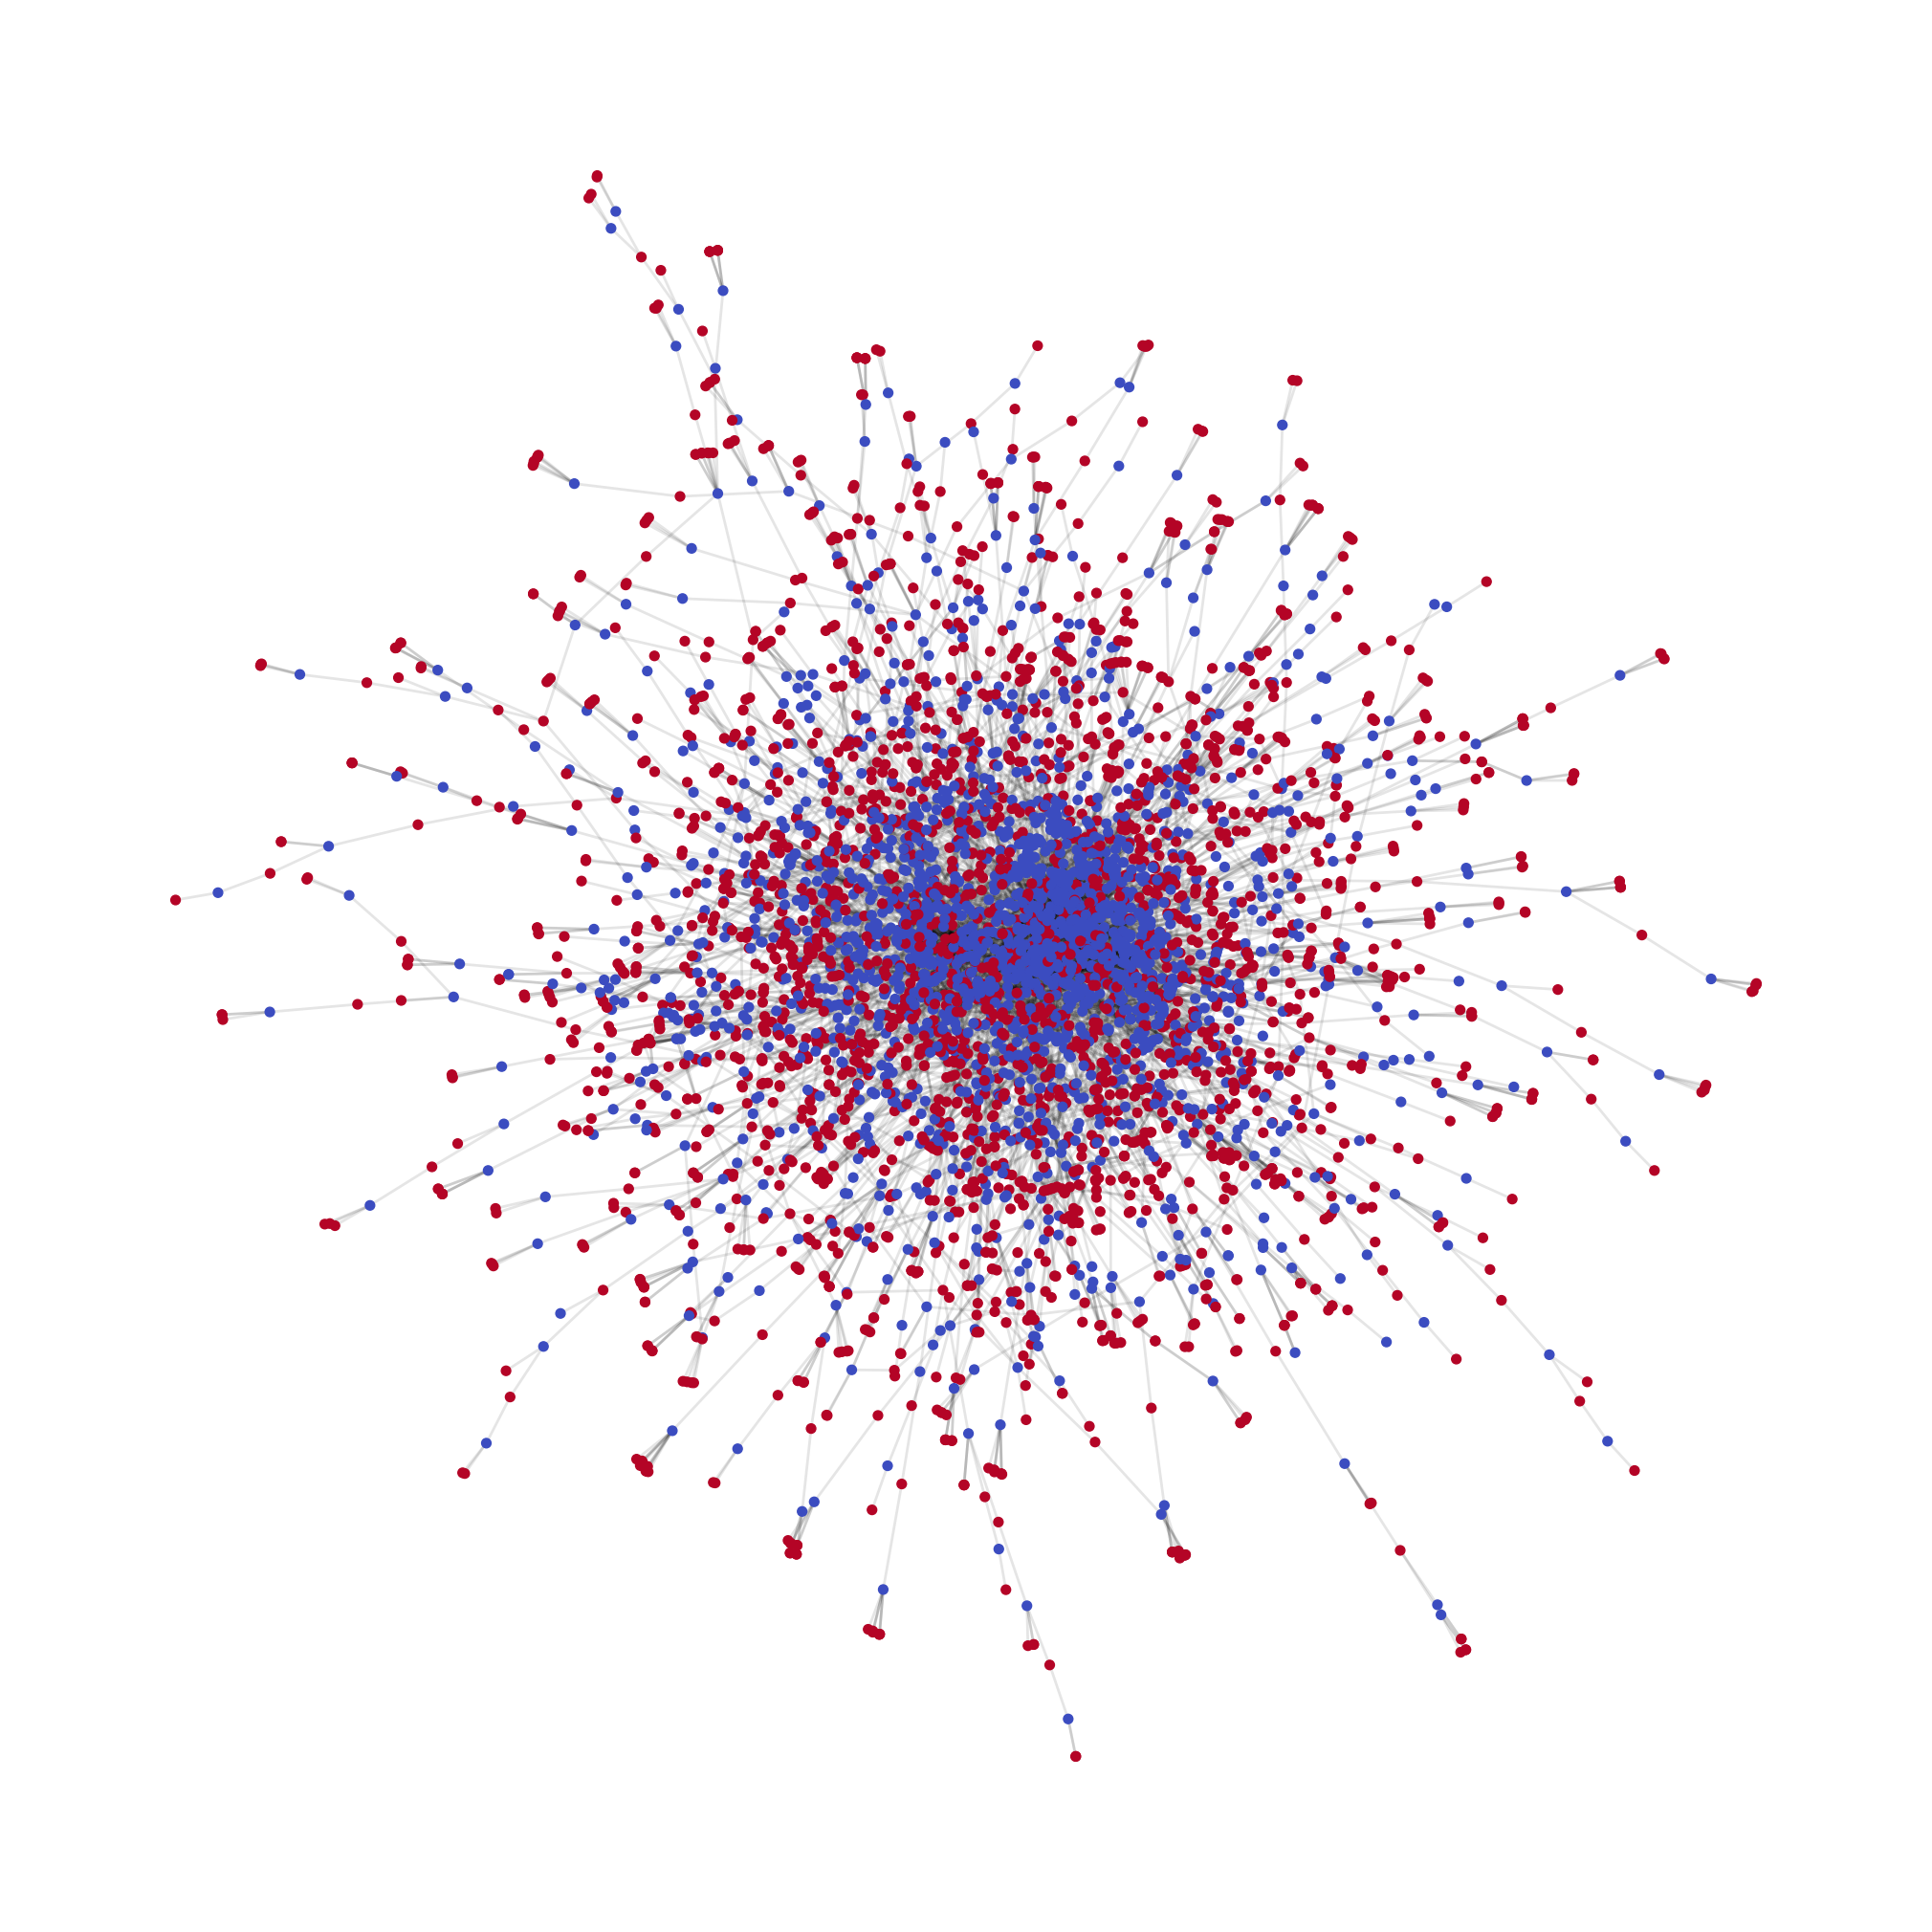

In [ ]:

nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))
plt.figure(figsize=(20,20))

In [ ]:
color_map = {"session": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_sm.nodes(data=True)]

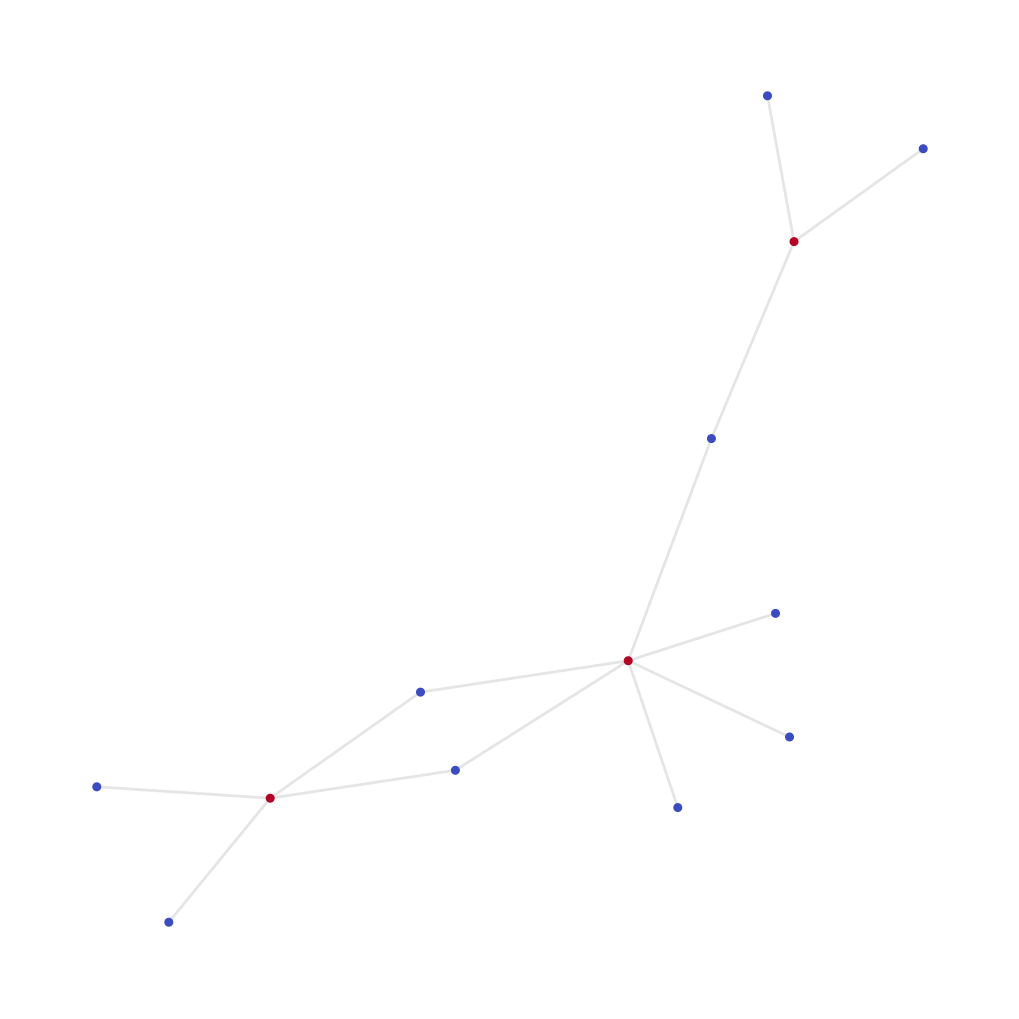

In [ ]:

nx.draw(sub_G_sm,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 2,
        edge_color=(0, 0, 0, 0.1))
plt.figure(figsize=(10,10))

In [ ]:
top = nx.bipartite.sets(sub_G_sm)[0]
pos = nx.bipartite_layout(sub_G_sm, top)

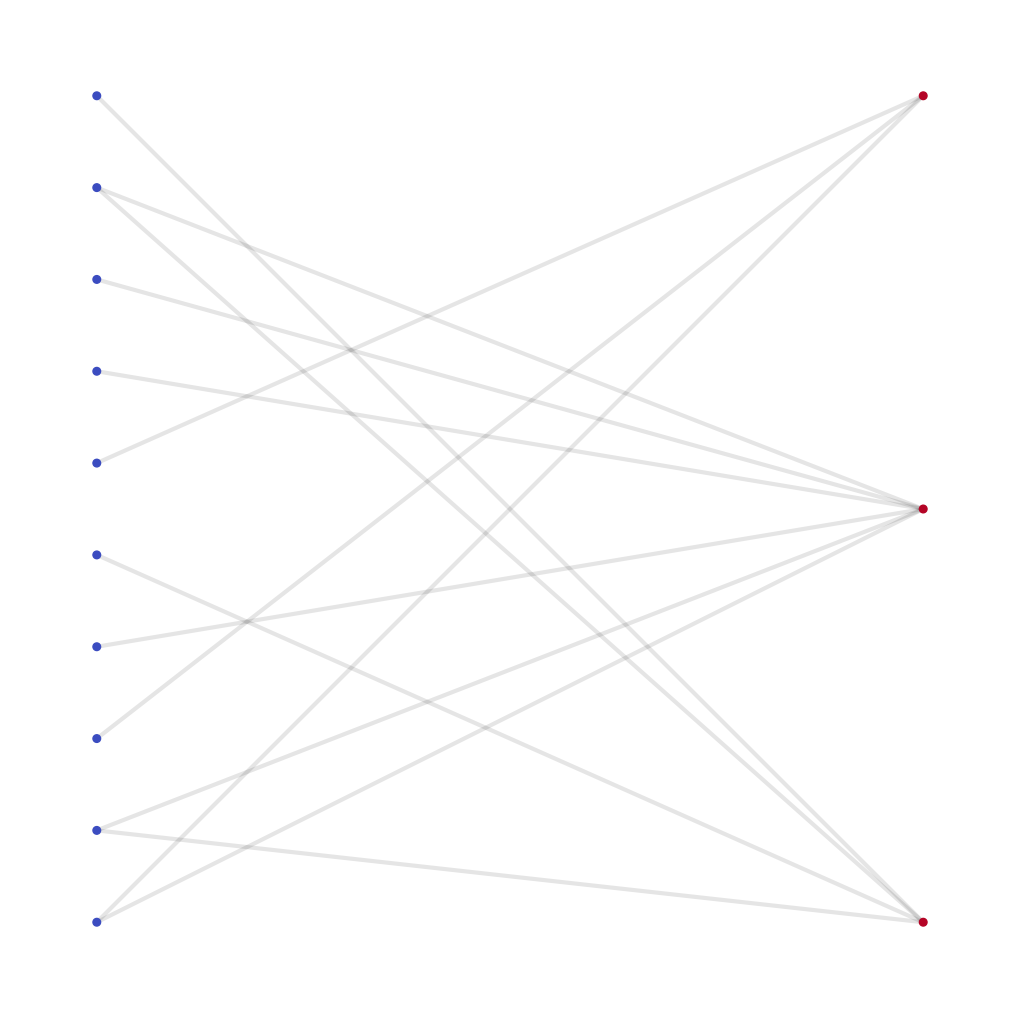

In [ ]:

nx.draw(sub_G_sm,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))
plt.figure(figsize=(10,10))

## Constructing a graph dataset

In [ ]:

graphs = {}
for k in ["train", "val", "test"]:
  G = pickle.load(open(f"{k}_graph.pkl", "rb"))
  print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())
  graphs[k] = G

Num nodes: 14154 . Num edges: 47909
Num nodes: 1521 . Num edges: 3812
Num nodes: 1544 . Num edges: 4117


In [ ]:
sorted_nodes = []
n_nodes = 0
for k, G in graphs.items():
  n_nodes += G.number_of_nodes()
  sorted_nodes.extend(list(G.nodes()))

sorted_nodes = sorted(sorted_nodes)
node2id = dict(zip(sorted_nodes, np.arange(n_nodes).tolist()))
id2node = dict(zip(np.arange(n_nodes).tolist(), sorted_nodes))

for k, G in graphs.items():
  graphs[k] = nx.relabel_nodes(G, node2id)

In [ ]:

session_idx = [i for i, v in enumerate(node2id.keys()) if v.split('_')[0] != 't']
tracks_idx = [i for i, v in enumerate(node2id.keys()) if v.split('_')[0] == 't']
print(len(session_idx), len(tracks_idx))
n_session = np.max(session_idx) + 1
n_tracks = n_nodes - n_session

n_session, n_tracks

7976 7623


(7976, 9243)

In [ ]:
num_nodes = n_session +  n_tracks
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0, num_test=0
)

In [ ]:

train_split = transform(Data(edge_index=torch.Tensor(np.array(graphs["train"].edges()).T), num_nodes=num_nodes))[0]
val_split = transform(Data(edge_index=torch.Tensor(np.array(graphs["val"].edges()).T), num_nodes=num_nodes))[0]
test_split = transform(Data(edge_index=torch.Tensor(np.array(graphs["test"].edges()).T), num_nodes=num_nodes))[0]

In [ ]:

train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)

train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)


In [ ]:

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 23208 positives upervision edges
Validation set has 1915 positive supervision edges
Test set has 2100 positive supervision edges
Train set has 46416 message passing edges
Validation set has 3830 message passing edges
Test set has 4200 message passing edges


## Util Functions

In [ ]:

def create_hard_negative_samples(dataset, model, num_sessions, num_tracks, device=None, batch_size=500, frac_sample=1):
    with torch.no_grad():
        embeddings = model.get_embedding(dataset.edge_index)
        sessions_embeddings = embeddings[:num_sessions].to(device)
        tracks_embeddings = embeddings[num_sessions:].to(device)

    pos_sessions, pos_tracks = dataset.edge_label_index
    num_positive_edges = pos_sessions.size(0)

    positive_mask = torch.zeros(num_sessions, num_tracks, device=device, dtype=torch.bool)
    positive_mask[pos_sessions, pos_tracks - num_sessions] = True

    hard_neg_edges_list = []
    hard_neg_edge_labels_list = []

    for batch_start in range(0, num_positive_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_positive_edges)

        batch_scores = torch.matmul(
            sessions_embeddings[pos_sessions[batch_start:batch_end]], tracks_embeddings.t()
        )

        batch_scores[positive_mask[pos_sessions[batch_start:batch_end]]] = -float("inf")

        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 * num_tracks), size=(batch_end - batch_start,))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + num_sessions

        hard_neg_edges_batch = torch.stack(
            (pos_sessions[batch_start:batch_end], top_indices_selected), dim=0
        )
        hard_neg_edge_labels_batch = torch.zeros(hard_neg_edges_batch.shape[1], device=device)

        hard_neg_edges_list.append(hard_neg_edges_batch)
        hard_neg_edge_labels_list.append(hard_neg_edge_labels_batch)

    hard_neg_edges = torch.cat(hard_neg_edges_list, dim=1)
    hard_neg_edge_labels = torch.cat(hard_neg_edge_labels_list)

    return hard_neg_edges, hard_neg_edge_labels


In [ ]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        sessions_embeddings = embeddings[:n_session]
        tracks_embeddings = embeddings[n_session:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_session, batch_size):
        batch_end = min(batch_start + batch_size, n_session)
        batch_sessions_embeddings = sessions_embeddings[batch_start:batch_end]

        scores = torch.matmul(batch_sessions_embeddings, tracks_embeddings.t())

        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_session] = -float("inf")

        _, top_k_indices = torch.topk(scores, k, dim=1)

        ground_truth_edges = data.edge_label_index

        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_session] = True

        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    
    recall_at_k = torch.mean(recall_at_k)

    return recall_at_k.item()

In [ ]:
def predict_embedding_scores(embeddings, edge_label_index):
    embedding_src = embed[edge_label_index[0]]
    embedding_dst = embed[edge_label_index[1]]
    return (embedding_src * embedding_dst).sum(dim=-1)

In [ ]:

def train(datasets, model, optimizer, args, neg_samp = "random"):
  
  train_data = datasets["train"].to(args['device'])
  val_data = datasets["val"].to(args['device'])

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): 
    model.train()
    optimizer.zero_grad()

    if neg_samp == "random":
      neg_edge_index = negative_sampling(train_data.edge_label_index)
      neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0:
        neg_edge_index, neg_edge_label = create_hard_negative_samples(train_data, model, n_session, n_tracks, 
                                                                    args["device"], batch_size = 500, frac_sample = 1 - (0.5 * epoch / args["epochs"]))
    embed = model.get_embedding(train_data.edge_index)
    
    pos_scores = predict_embedding_scores(embed, train_data.edge_label_index)
    neg_scores = predict_embedding_scores(embed, neg_edge_index)

    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 1e-2)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_recall, val_neg_edge, val_neg_label = test(model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label)

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)
    stats['val']['recall'].append(val_recall)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}; Val recall {val_recall}")

  return stats

def test(model, data, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None, device=None):

  data.to(device)
  model.eval()
  with torch.no_grad(): 

    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_session, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None:
        neg_edge_index, neg_edge_label = create_hard_negative_samples(data, model, n_session, n_tracks, 
                                                                    args["device"], batch_size = 500, frac_sample = 1 - (0.5 * epoch / args["epochs"]))
    embed = model.get_embedding(data.edge_index)
    
    pos_scores = predict_embedding_scores(embed, data.edge_label_index)
    neg_scores = predict_embedding_scores(embed, neg_edge_index)
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    
    loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = roc_auc_score(labels.flatten().cpu().numpy(), scores.flatten().data.cpu().numpy())
    recall = recall_at_k(data, model, k = 5, device = args["device"])

  return loss, roc, recall, neg_edge_index, neg_edge_label

## Model Training

In [ ]:

datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [ ]:
args = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers':  2,
    'emb_size': 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 100
}

In [ ]:
def init_model(args):
  num_nodes = n_session + n_tracks
  model = LightGCN(num_nodes=num_nodes, embedding_dim=args["emb_size"], num_layers=args["num_layers"])
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer

In [ ]:

neg_samp = "hard"

In [ ]:

model, optimizer = init_model(args)
lgc_stats_hard = train(datasets, model, optimizer, args, neg_samp = neg_samp)
# torch.save(model.state_dict(), f"{model.name}_{neg_samp}.pt")

In [ ]:
_, roc, recall, _, _ = test(model, datasets['test'], neg_samp = neg_samp, device=args["device"])

In [ ]:
roc, recall

In [ ]:

neg_samp = "random"

In [ ]:

model, optimizer = init_model(args)
lgc_stats = train(datasets, model, optimizer, args, neg_samp = neg_samp)
# torch.save(model.state_dict(), f"{model.name}_{neg_samp}.pt")

In [ ]:
_, roc, recall, _, _ = test(model, datasets['test'], neg_samp = neg_samp, device=args["device"])

In [ ]:
roc, recall

In [ ]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.set_title("Train/Val loss")
  plt.show()

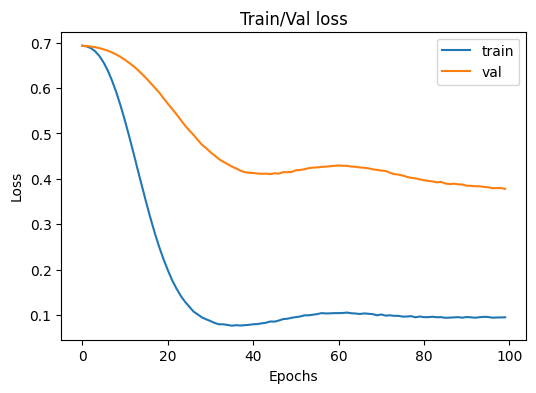

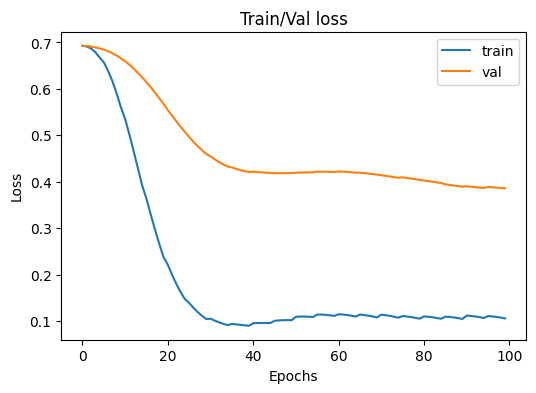

In [ ]:
plot_train_val_loss(lgc_stats)
plot_train_val_loss(lgc_stats_hard)